In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj,get_prop_abs, create_R
from setup import setup_matplotlib
from scipy.linalg import expm
from scipy.sparse import csr_array, coo_array

setup_matplotlib()

np.random.seed(42)

In [24]:
k = 1
s = 1
D = s**2/2
N_t = 200
ntau = 3
dx = 0.3
sb = 17.5*dx #with .5, 0 not included

f = 15
N_p = 16_000


x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

border = dx*8.5 #same
def cusp_force(x, thresh = 1e-7):
    if x < -thresh:
        return -k*(x+border)
    elif x > thresh:
        return -k*(x-border)
    else:
        return 0
force = np.vectorize(cusp_force)

i_zero = np.argmin((x_s+border)**2)


#ltaus = np.concatenate(([0.05], np.arange(0.2,1.8,0.2) ))

ltaus = [0.5]

In [25]:
for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx)
    R, _, end_states = create_R_v1(N_x, ntau, prop)
    
    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,border=border, force=force)
    all_pos = pos[0]
    sim_hists = np.stack([np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]), leave=False)])
 

    break

    
# with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}_x4.pkl', 'wb') as file:
#     pickle.dump({'ltaus':ltaus,
#                  'sim_vars':sim_vars,
#                  'sim_hist_vars':sim_hist_vars,
#                  'num_vars':num_vars
#                 }, file)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/2999 [00:00<?, ?it/s]

  0%|          | 0/3045 [00:00<?, ?it/s]

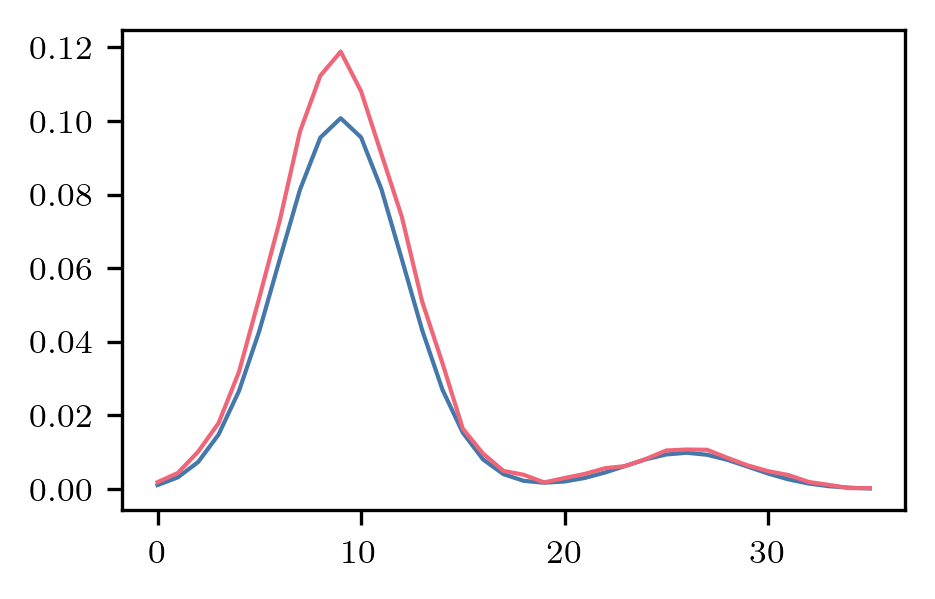

In [26]:
idx = 199
plt.plot(hists[idx])
plt.plot(sim_hists[(idx+ntau)*f]/N_p)
#plt.yscale('log')

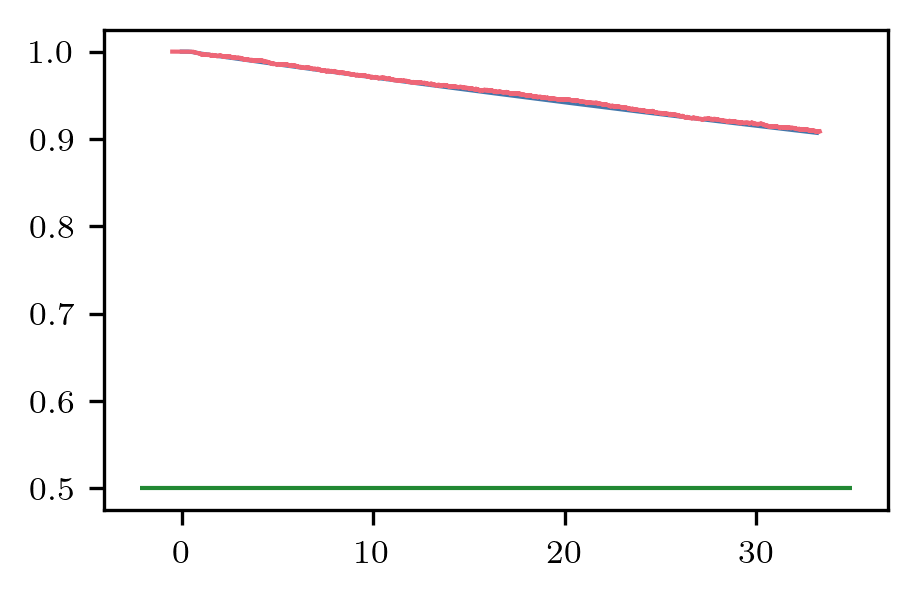

In [27]:
ts = np.arange(0,N_t)*ldt
sim_ts = np.arange(0,f*N_t+ntau*f)*ldt/f-ltau
plt.plot(ts,np.sum(hists[:,x_s < 0], axis = 1)/np.sum(hists, axis = 1))
plt.plot(sim_ts,np.sum(sim_hists[:,x_s < 0], axis = 1)/N_p)
plt.hlines(0.5,*plt.xlim(), color = 'C2')